# BINF GU 4002: Machine Learning for Healthcare, Spring 2025
# Assignment \#2: Regularization and Model Selection
## DUE: 11:59 PM, Tuesday, March 11, 2025

This assignment explores regularization and model selection. We will use ideas explored in class and build intuition around how to select appropriate modelling techniques for the specific data and task you have. As an illustrative example, you will be using embeddings generated from a large-scale protein language model to predict the structural effects of a mutation in the protein sequence.

**<font color="red">Instructions: Please run the notebook using Google Colab to prevent any dependency / package issues. Make sure that your written answers are formatted using </font>$\LaTeX$<font color="red"> in `markdown` cells. When submitting, please name your files `{UNI}_binf4002_mlhc_assignment_2.{filetype}` and submit a `.ipynb` version of your Jupyter notebook. Additionally, we will render the jupyter notebook using nbviewer (https://nbviewer.org/). When you are submitting your final version, upload your homework to a public github repository and paste the github link to nbviewer and obtain the final rendered link </font>**

Link to github repository: https://github.com/em3697/em3697_binf4002_mlhc_assignment_2

Link to nbviewer render:https://nbviewer.org/github/em3697/em3697_binf4002_mlhc_assignment_2/blob/main/em3697_binf4002_mlhc_assignment_2.ipynb


#### The Problem and Data

We will be using data from the [Envision](https://pmc.ncbi.nlm.nih.gov/articles/pmid/29226803/) paper (Gray et al.2018). The goal is to perform variant effect prediction, where variants of β-Lactamase are created by through single-residue mutations (one amino-acid is replaced by another amino-acid in the protein sequence). The data is generated using a method called deep mutational scan.

From Gray et al. 2018:

> In a deep mutational scan, selection for protein function among a library of nearly all possible single amino acid variants of a protein is coupled to high-throughput DNA sequencing (Fowler and Fields, 2014; Fowler et al., 2014). Sequencing reveals how each variant’s frequency changes during selection, yielding quantitative scores that describe the functional effect of each variant in the library. A large-scale mutagenesis dataset contains deep and unbiased information, capturing the effects of most variants at every position in a single protein. We hypothesize that large-scale mutagenesis datasets contain informative and generalizable patterns that can be used to predict variant effects in disparate proteins.

The prediction target is a quantitative metric known as variant effect score, which depends on the protein of interest. For example, this score may capture the severity of functional disruption.

The embeddings are generated from [ESM](https://www.nature.com/articles/s41588-023-01465-0), a large-scale language (foundation) model for protein sequences developed by Meta AI. The repository can be found here: https://github.com/facebookresearch/esm/tree/main  

In [2]:
# STARTER CODE
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls

FASTA_PATH = "/content/P62593.fasta" # Path to P62593.fasta
EMB_PATH = "/content/P62593_reprs" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-272_yvq1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-272_yvq1
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fair-esm: filename=fair_esm-2.0.1-py3-none-any.whl size=105419 sha256=67af8caa38ccd0f2d0d8fa297f613282cf4b363f82706a07eb00fc07b7d276a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-akszvkx2/wheels/73/b8/59/2a3415340d3dec5ae3d9ce69f8d7eb22674be68a4402b39f7a
Successfully built fair-esm
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  7290k      0  0:00:03  0:00:03 --:--:-- 7290k
 

In [3]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

import esm

ys = []
Xs = []

for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()

train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

print(Xs.shape)

<ipython-input-3-e907ffff8eb5>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(fn)


(5397, 1280)


#### Data exploration

Note that the embeddings are high-dimensional. To qualitatively analyse if there are patterns (ex. naturally-forming clusters) in the data, we can visualize the data using dimensionality reduction. The color indicates the level of functional distruption in the protein, and each point represents a different amino-acid sequence containing a specific mutation.

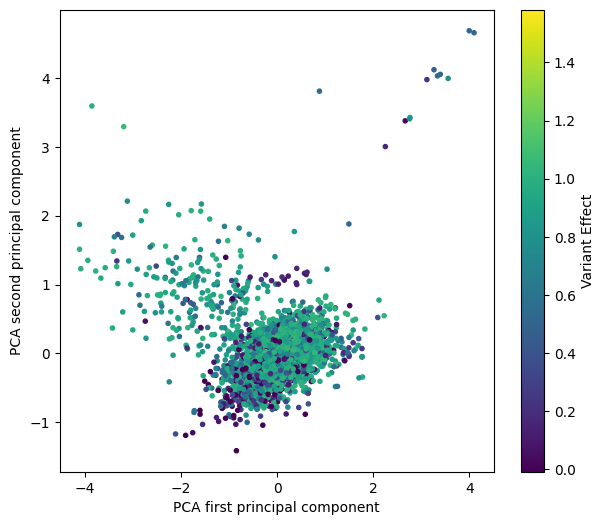

In [4]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')
plt.show()

## [30 Points] Question 1: Bias Variance Tradeoff

Modeling data in healthcare is often in a data-constrained setting, where we may be restricted to high dimensional data with limited samples due to costs of experimentation and data acquisition. However, a key desiderata for our models is the ability to generalize to unseen samples.

How do we know if we have enough data for a given modelling task to achieve generalization? How do we choose the right modeling strategy? We will explore these questions using a phenomenon in machine learning known as the bias-variance tradeoff.

Consider a dataset $$D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n) \}$$

and suppose that the relationship between $x \in \mathbb{R}^1$ and $y \in \mathbb{R}^1$ values are specified by an unknown true underlying function as $y = f(x) + \epsilon$ where $\epsilon \sim N(0, \sigma^2)$.

Now, suppose we have trained an approximation of the underlying true function using the training dataset with $\hat{y} = \hat{f}(x)$, where $\hat{y}$ corresponds to the prediction of $y$

#### [15 Points] 1.1: Prove the bias-variance decomposition of mean squared error
$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{Bias^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{Variance}$$

Answer:

$y=f(x)+\epsilon$ is the true value with noise $\epsilon$ where $\mathbb{E}(\epsilon)=0$ and $\operatorname{Var}(\epsilon)=\sigma^{2}$

$\hat{f}(x)$ is our models prediction from training on $D$


MSE $=\frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}=\mathbb{E}_{D}\left[(y-\hat{f}(x))^{2}\right]$ if we use expected value notation and our prediction model to represent $\hat{y}$


Since $y=f(x)+\epsilon$ we can further rewrite this as $\mathbb{E}_{D}\left[(f(x)+\epsilon-\hat{f}(x))^{2}\right]$


We can also write $\mathbb{E}_{D}[\hat{f}(x)]$ as $\mu(x)$ as the expected prediction across all possible training datasets


We want to introduce this term to account for average prediction \& to get the equation in the desired form.

$$
\begin{aligned}
& \mathbb{E}_{D}\left[(f(x)+\epsilon-\mu(x)+\mu(x)-\hat{f}(x))^{2}\right] \\
& =\mathbb{E}_{D}\left[((f(x)-\mu(x))+\epsilon+(\mu(x)-\hat{f}(x)))^{2}\right]
\end{aligned}
$$

This expands to
$$
\mathbb{E}_{0}\left[(f(x)-\mu(x))^{2}+\epsilon^{2}+(\mu(x)-\hat{f}(x))^{2}+2(f(x)-\mu(x)) \epsilon+2(f(x)-\mu(x))(\mu(x)-\hat{f}(x))+2 \epsilon(\mu(x)-\hat{f}(x))\right]
$$

We can take the expectation by term now:
- $(f(x)-\mu(x))^{2}$ is constant writ $D$
- $\mathbb{E}_{D}\left[\epsilon^{2}\right]=\sigma^{2}$ or the noise variance
- $\mathbb{E}_{D}\left[(\mu(x)-\hat{f}(x))^{2}\right]=\mathbb{E}_{D}\left[(\hat{f}(x)-\mu(x))^{2}\right]$ since we square the difference the order of the subtraction doesn't effect the value giving us $\operatorname{Var}(\hat{f}(x))$
- $\mathbb{E}_{D}[2(f(x)-\mu(x)) \epsilon]=2(f(x)-\mu(x)) \mathbb{E}_{D}[\epsilon]=0$ since $\mathbb{E}[\epsilon]=0$
$$
\begin{aligned}
& \mathbb{E}_{D}[2(f(x)-\mu(x))(\mu(x)-\hat{f}(x))]=2(f(x)-\mu(x)) \mathbb{E}_{D}[\mu(x)-\hat{f}(x)]=0 \text { since } \\
& \mathbb{E}_{D}[\hat{f}(x)]=\mu(x) \\
& \cdot \mathbb{E}_{D}[2 \in(\mu(x)-\hat{f}(x))]=2 \mathbb{E}[\epsilon] \mathbb{E}_{D}[\mu(x)-\hat{f}(x)]=0 \text { since } \mathbb{E}[\epsilon]=0
\end{aligned}
$$

If we substitute these back
$$
\mathbb{E}_{D}\left[(y-\hat{f}(x))^{2}\right]=(f(x)-\mu(x))^{2}+\sigma^{2}+\mathbb{E}_{D}\left[(\hat{f}(x)-\mu(x))^{2}\right]
$$

Substituting back $\mu(x)=\mathbb{E}_{D}[\hat{f}(x)]$ we get
$$
\mathbb{E}_{D}\left[(y-\hat{f}(x))^{2}\right]=\underbrace{\left(f(x)-\mathbb{E}_{D}[\hat{f}(x)]^{2}\right.}_{\text {Bias }^{2}}+\underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x)-\mathbb{E}_{D}[\hat{f}(x)]\right)^{2}\right]}_{\text {Variance }^{2}}+\underbrace{\sigma^{\sigma^{2}}}_{\substack{\text { error } \\ \text { due to noise }}}
$$

#### [5 Points] 1.2: What does it mean for the prediction model $\hat{f}(x)$ to have high bias? What are potential causes of high bias?

Answer: High bias indicates a failure of the prediction model to truly capture the underlying pattern in the data. This results in the average prediction varying from the true function. Many things can cause high bias. Some include underfitting due to too simple of a model, incorrect assumptions of relationships by the model, missing critical features from your dataset, or too much regularization.


#### [5 Points] 1.3: What does it mean for the model to have high variance? What are potential causes of high variance?

Answer: High variance means that the model produces very different predictions depending on which subset it is trained on. Essentially this means the model is highly sensitive to small changes in training data changes from the same distribution. This can arise from model overfitting due to high model complexity, not having enough training data to learn the true patterns in the data, not using regularization resulting in extreme values, noise in the underlying data or a very high dimensional feature space with not enough samples.

#### [5 Points] 1.4 Can bias and variance decrease at the same time?

Answer: Yes you can decrease both using different methods. The primary way is to increase your training dataset. Additionally things like balanced choices in regularization and models can have the same effect. Sampling methods like bootstrapping or boosting, feature selection, and pretrained or fine-tuned models can also have the same impact on bias and variance.


# [30 Points] Question 2: Regularization

A model with high bias is also called "underfitting", while a model with high variance is also called "overfitting". One idea from the bias-variance tradeoff is that purposefully introducing bias may be an effective strategy in mitigating overfitting and reducing variance.

We will now explore regularization, a common strategy used to introduce bias in the model to improve generalization.

Consider a dataset $$D = \{(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n) \}$$

where now each sample contains a vector of $d$ features $\textbf{x}_i \in \mathbb{R}^{d \times 1}$

Suppose we specifiy our model to be a linear regression model. That is, we consider a model with a vector of parameters $\beta \in \mathbb{R}^{d \times 1}$ such that $y_i = \textbf{x}_i^T \beta + \epsilon $

Note that we can equivalently write the set of $n$ equations stacked together using a matrix $\textbf{X} \in \mathbb{R}^{n \times d}$ and $\textbf{y} \in \mathbb{R}^{n \times 1}$ as follows:

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

#### [10 Points] Question 2.1: Derive the optimal solution to the L2-regularized Squared Error Loss (also known as ridge regression) given by

$$(\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta $$

Answer:


The equation for $L 2$-regularized Squared Error Loss:
$$
L(\beta)=(X \beta-y)^{\top}(X \beta-y)+\lambda \beta^{\top} \beta
$$

To optimize we must take the derivative wot $\beta$ and set it equal to 0 First we expand the error term products:
$$
(x \beta-y)^{\top}(x \beta-y)=(x \beta)^{\top}(x \beta)-(x \beta)^{\top} y-y^{\top}(x \beta)+y^{\top} y
$$

If we apply matrix properties:
$$
\begin{aligned}
& (X \beta)^{\top}=\beta^{\top} x^{\top} \\
& (x \beta)^{\top} y=y^{\top}(X \beta)
\end{aligned}
$$
we get:
$$
L(\beta)=\beta^{\top} X^{\top} x \beta-2 y^{\top} X \beta+y^{\top} y+\lambda \beta^{\top} \beta
$$

Now we take the derivative wot $\beta$
$$
\begin{aligned}
& \frac{\partial}{\partial \beta}\left(\beta^{\top} x^{\top} x \beta\right)=2 x^{\top} x \beta \\
& \frac{\partial}{\partial \beta}\left(2 y^{\top} x \beta\right)=2 x^{\top} y \\
& \frac{\partial}{\partial \beta}\left(\lambda \beta^{\top} \beta\right)=2 \lambda \beta \\
& \frac{\partial L}{\partial \beta}=2 x^{\top} x \beta-2 x^{\top} y+2 \lambda \beta=0 \\
& 2 x^{\top} x \beta+2 \lambda \beta=2 x^{\top} y \\
& x^{\top} x \beta+\lambda \beta=x^{\top} y
\end{aligned}
$$
$$
\begin{aligned}
& \beta\left(x^{\top} x+\lambda\right)=x^{\top} y \\
& \beta=\frac{x^{\top} y}{x^{\top} x+\lambda}
\end{aligned}
$$

#### [15 Points] Question 2.2: Build a Ridge Regression with the skeleton code below (Fill in TODOs).

#### [5 Points] Question 2.3: What do you notice in the relationship between MSE and variance as we increase the lambda parameter?

Answer: At first, with low values of lambda MSE and Variance are comparable with slightly higher variance. As we increase lambda you can see MSE and Variance converge and then MSE begins to surpass Variance at a lambda value of 10.



In [9]:
class RidgeRegression:
    def __init__(self, lambda_reg=1.0):
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.beta = None  # Coefficients

    def fit(self, X, y):
        """ Compute the closed-form solution for Ridge Regression. """
        n, d = X.shape
        I = np.eye(d)  # Identity matrix
        XTX = X.T @ X  # Compute X^T X
        XTy = X.T @ y  # Compute X^T y

        # Closed-form solution
        self.beta = np.linalg.inv(XTX + self.lambda_reg * I) @ XTy

    def predict(self, X):
        """ Predict using the learned weights. """
        return X @ self.beta

    def mse(self, y_true, y_pred):
        """ Compute Mean Squared Error (MSE). """
        return np.mean((y_true - y_pred)**2)

In [10]:
# Define a range of lambda values
lambdas = np.logspace(-3, 3, 30)  # From 0.001 to 1000
mse_values = []
variance_values = []

# Compute bias and variance for each lambda
for lambda_reg in lambdas:
    model = RidgeRegression(lambda_reg)
    model.fit(Xs_train, ys_train)

    predictions = model.predict(Xs_test)
    mse = np.mean((ys_test - predictions) ** 2)
    variance = np.var(predictions)

    mse_values.append(mse)
    variance_values.append(variance)

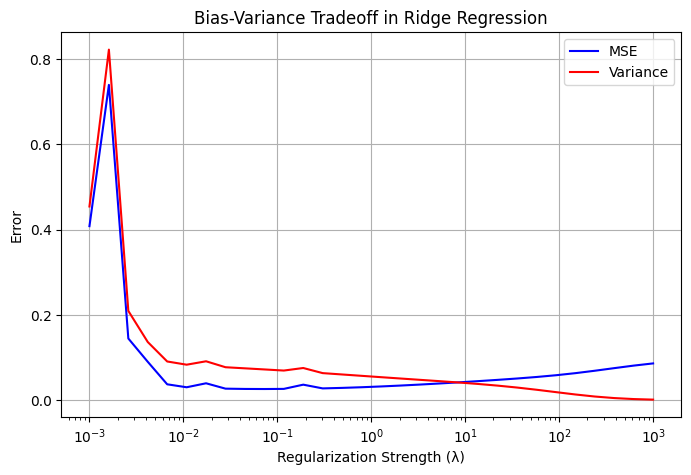

In [11]:
# Plotting Code for question 2.3

plt.figure(figsize=(8, 5))
plt.plot(lambdas, mse_values, label="MSE", color='blue')
plt.plot(lambdas, variance_values, label="Variance", color='red')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (λ)")
plt.ylabel("Error")
plt.title("Bias-Variance Tradeoff in Ridge Regression")
plt.legend()
plt.grid()
plt.show()

# [20 Points] Question 3: Bayesian Variable Selection

Follwing the intuition we have built around regularization, we will now explore a more complex Bayesian model for the protein variant effect prediction task. We assume the same linear model with the same dimensionality as before

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

However, now we will introduce a prior on the model parameters $\beta$. For each $\beta_j$ where $j=1, ..., d$, the prior takes the following form

$$ \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , } \quad \gamma_j \sim \text{Bernoulli}(p)$$

Equivalently, we can rewrite the resulting model in a slightly more compact form where $\circ$ indicates a element-wise (hadamard) product between two vectors.

$$ \beta \sim N(0, \sigma_\beta^2) $$
$$ \textbf{y}_i | \textbf{x}_i, \beta, \gamma \sim N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2)$$


#### [5 Points] 3.1: What is the role of the $\gamma$ parameter in determining $\beta$ in the prior? What happens when $\gamma = 1$ and $\gamma = 0$?

Answer: The variable 𝛾 acts as a binary indicator given it comes from a Bernoulli distribution where it can take on a value of either 1 or 0. This controls whether 𝛽𝑗 is zero or non-zero. When 𝛾𝑗 = 1, 𝛽𝑗 is a normal distribution 𝑁(0,𝜎2𝛽). Howeverm when 𝛾𝑗 = 0, 𝛽𝑗 is represented as 0.Thus depending on this variable coefficients either are zero or follow a normal distribution, allowing for feature selection effectively.

#### [10 Points] 3.2: We would like to fit the parameters $\gamma, \beta$ using MAP estimation. Write the posterior objective $p(\gamma, \beta | \textbf{X}, \textbf{y})$ in terms of the priors and likelihoods. (We will assume $\sigma^2$ is fixed for purposes of this problem)

Hints: Recall the posterior probability we wish to maximize given data is $p(\theta | \text{X}, \text{y}) \propto p(\theta) \prod_i^n p(y_i |x_i, \theta) $. What are the distributional families of the priors and likelihoods?

Answer:


Deriving the posterior objective for MAP estimation of $\gamma$ and $\beta$
- Like linood: $y_{1} \mid x_{1}, \beta, \gamma \sim N\left((\gamma \cdot \beta)^{\top} x_{1}, \sigma^{2}\right) \rightarrow p\left(y \mid x_{1} \gamma, \beta\right)$
- Prior on $\beta: \beta \sim N\left(0, \sigma^{2} \beta\right)$
- Prior on $\gamma: \gamma_{j} \sim \operatorname{Bernoulli}(p)$ for $\left.j=1, \ldots, d\right\} p(\gamma, \beta)$
we want to find $p(\gamma, \beta \mid x, y)$
using Bayes' rule:
$$
p(\gamma, \beta \mid x, y)=\frac{p(y \mid x, \gamma, \beta) \cdot p(\gamma, \beta)}{p(y \mid x)}
$$

Since for MAP we want to find $\gamma, \beta$ to maximize the posterior probability, and $p(y \mid X)$ doesn't depend on $\gamma$ or $\beta$ we can say:
$$
p(\gamma, \beta \mid x, y) \propto p(\gamma, \beta) \cdot p(y \mid x, \gamma, \beta)
$$

The joint prior can be written as:
$$
p(\gamma, \beta)=p(\beta) \cdot p(\gamma)
$$

The prior on $\beta$ :
$$
p(\beta)=\frac{1}{\left(2 \pi \sigma_{B}^{2}\right)^{d / 2}} \exp \left(-\frac{1}{2 \sigma_{B}^{2}} \beta^{\top} \beta\right)
$$

The prior on $\gamma$ :
$$
p(\gamma)=\prod_{j=1}^{\alpha} p^{\gamma_{j}}(1-p)^{1-\gamma_{j}}
$$

Likelihood:
$$
p(y \mid x, \gamma, \beta)=\prod_{i=1}^{n} p\left(y_{i} \mid x_{i}, \gamma, \beta\right)
$$

Each individual likelihood:
$$
p\left(y_{i} \mid x_{i}, \gamma, \beta\right)=\frac{1}{\sqrt{2 \pi \sigma^{2}}} \exp \left(-\frac{\left(y_{i}-(\gamma \cdot \beta)^{\top} x_{i}\right)^{2}}{2 \sigma^{2}}\right)
$$
combining:
$$
\begin{aligned}
& p(\gamma, \beta \mid x, y) \propto \frac{1}{\left(2 \pi \sigma_{\beta}^{2}\right)^{\alpha / 2}} \exp \left(-\frac{1}{2 \sigma_{B}^{2}} \beta^{\top} \beta\right) \prod_{j=1}^{\alpha} p^{\gamma_{j}}(1-p)^{1-\gamma_{j}} \\
& \cdot \frac{1}{\left(2 \pi \sigma^{2}\right)^{n / 2}} \exp \left(-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{n}\left(y_{i}-(\gamma \cdot \beta)^{\top} x_{i}\right)^{2}\right)
\end{aligned}
$$

For MAD estimation we maximize the log posterior:
1. $\log \left[\frac{1}{\left(2 \pi \sigma_{\beta}^{2}\right)^{d / 2}}\right]=-\frac{d}{2} \log \left(2 \pi \sigma_{\beta}^{2}\right)$
2. $\log \left[\exp \left(-\frac{1}{2 \sigma_{\beta}^{2}} \beta^{\top} \beta\right)\right]=-\frac{1}{2 \sigma_{\beta}^{2}} \beta^{\top} \beta$
3. $\log \left[\prod_{j=1}^{d} p^{\gamma_{j}}(1-p)^{1-\gamma_{j}}\right]=\sum_{j=1}^{d}\left[\gamma_{j} \log (p)+\left(1-\gamma_{j}\right) \log (1-p)\right]$
4. $\log \left[\frac{1}{\left(2 \pi \sigma^{2}\right)^{n / 2}}\right]=-\frac{n}{2} \log \left(2 \pi \sigma^{2}\right)$
5. $\log \left[\exp \left(-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{n}\left(y_{i}-(\gamma \circ \beta)^{\top} x_{i}\right)^{2}\right)\right]=-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{n}\left(y_{i}-(\gamma \circ \beta)^{\top} x_{i}\right)^{2}$
$$
\begin{aligned}
\log p(\gamma, \beta \mid x, y)= & -\frac{d}{2} \log \left(2 \pi \sigma_{\beta}^{2}\right)-\frac{1}{2 \sigma_{\beta}^{2}} \beta^{\top} \beta+\sum_{j=1}^{d}\left[\gamma_{j} \log (p)+\left(1-\gamma_{j}\right) \log (1-p)\right] \\
& -\frac{n}{2} \log \left(2 \pi \sigma^{2}\right)-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{n}\left(v_{i}-(\gamma \circ \beta)^{\top} x_{i}\right)^{2}
\end{aligned}
$$
$$
\begin{aligned}
& \log p(\gamma, \beta \mid x, y)= \text { constant }-\frac{1}{2 \sigma_{\beta}^{2}} \beta^{\top} \beta+\sum_{j=1}^{d}\left[\gamma_{j} \log (p)+\left(1-\gamma_{j}\right) \log (1-p)\right] \\
&-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{n}\left(y_{i}-(\gamma \circ \beta)^{\top} x_{i}\right)^{2} \\
&=C-\frac{1}{2 \sigma_{\beta}^{2}} \beta^{\top} \beta+\sum_{j=1}^{d}\left[\gamma_{j} \log (p)+\left(1-\gamma_{j}\right) \log (1-p)\right]-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{n}\left(y_{i}-(\gamma \circ \beta)^{\top} x_{i}\right)^{2}
\end{aligned}
$$

#### [5 Points] 3.3: Run the code below to obtain the MAP estimate of the optimal parameters of $\gamma$. Interpret the plot. What does the posterior $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ being high or low indicate for a given $j \in \{1, ..., d\}$?

Answer: This plot shows the probability that 𝛾 is equal to 1 given the data for each feature in the data. For features where the probability is higher it indicates feature significance and that the model is confident it should be included in the final model. This will also result in a non-zero coefficient from the normal distribution as discussed earlier with the behavior of 𝛽𝑗 in this model. We can also see features with low probabilities which would indicate that they're unimportant to the model's prediction and will thus have a coefiicient of 0 to remove them from having prediction influence.

In [12]:
import pymc as pm

num_features = Xs_train.shape[1]

# Bayesian model with spike-and-slab prior (note this takes around 5 minutes)
# Note that in 3.2, the expression cannot be optimized analytically with a closed form solution.
# The following code uses an iterative gradient decsent optimization procedure to find a local maximum

with pm.Model() as model:
    logit_gamma = pm.Normal("logit_gamma", mu=0, sigma=1, shape=num_features)
    gamma = pm.Deterministic("gamma", pm.math.sigmoid(logit_gamma))  # Continuous approximation of bernoulli to speed up gradient-based optimization

    beta = pm.Normal("beta", mu=0, sigma=1, shape=num_features) * gamma
    sigma = pm.HalfNormal("sigma", sigma=1) # This is a normal distribution but only takes positive values (positive half of a normal distribution)

    mu = pm.math.dot(Xs_train, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=ys_train)

    map_estimate = pm.find_MAP()


Output()

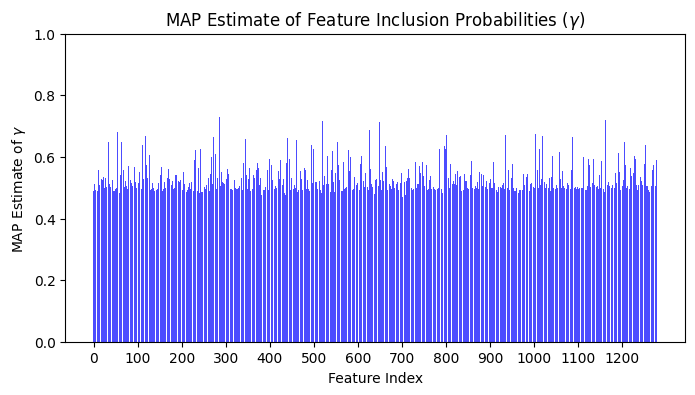

In [13]:
gamma_map = map_estimate["gamma"]

# Plot the MAP estimate of gamma
plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(gamma_map)), gamma_map, color="blue", alpha=0.7)
plt.xlabel("Feature Index")
plt.ylabel("MAP Estimate of $\gamma$")
plt.title("MAP Estimate of Feature Inclusion Probabilities ($\gamma$)")
plt.xticks(np.arange(0, len(gamma_map), 100))
plt.ylim(0, 1)  # Since gamma is in (0,1)
plt.show()

# [10 Points] Question 3: Model Selection & Cross Validation

Using the intuition we have built around regularization, we will now explore practical strategies for selecting the best parameters for a model. We will use the following function to perform cross validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### [10 Points] 3.1: Define a range of parameters and number of cross validation folds. Report the best parameter and mean squared error obtained on the held-out testing data

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge_model = Ridge()

# Define hyperparameter grid for Ridge Regression (This is only graded on completion and not on model performance)
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Perform GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(ridge_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(Xs_train, ys_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.09577e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.57121e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.26944e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [15]:
best_mse = -grid_search.best_score_  # Convert from negative MSE back to regular MSE
print(f"Best MSE: {best_mse}")

Best MSE: 0.029813742265105247
